# Step51, MNIST 학습 

지금까지 데이터셋을 쉽게 다룰 수 있는 구조를 마련하였다.

Dataset 클래스로 데이터셋 처리를 위한 공통 인터페이스를 마련, '전처리'를 설정할 수 있도록 하였다.  
DataLoader 클래스로 Dataset에서 미니배치 단위로 데이터를 꺼내올 수 있게 하였다.

이번단계에서는 MNIST 데이터셋을 다뤄본다.

## 51.1 MNIST 데이터셋 

dezero/datasets.py에 MNIST 클래스가 있다.  
MNIST 클래스는 Dataset 클래스를 상속하고 있다.

In [2]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

train_set = dezero.datasets.MNIST(train=True, transform=None)   # 아무 전처리를 하지않고 가져온다
test_set = dezero.datasets.MNIST(train=False, transform=None)

print(len(train_set))
print(len(test_set))

60000
10000


HTTPError: HTTP Error 503: Service Unavailable 이런 오류가 났다면  
datasets.py에 MNIST 클래스에 

url = 'http://yann.lecun.com/exdb/mnist/' 를 url = 'https://yann.lecun.com/exdb/mnist/'로 바꿔주면 된다.

In [3]:
x, t = train_set[0]
print(type(x), x.shape, t)

# 데이터는 (1,28,28)
# 라벨은 이 데이터가 5임을 알려준다.

<class 'numpy.ndarray'> (1, 28, 28) 5


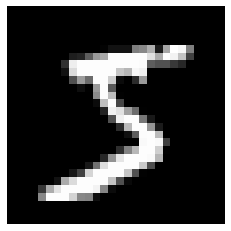

label: 5


In [4]:
import matplotlib.pyplot as plt 

x,t = train_set[0]      # 0번째 (data, label) 추출
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', t)

이 손글씨 이미지 데이터를 지금부터 신경망으로 학습하려면 입력데이터를 전처리해야한다.

In [5]:
def f(x):
    x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.0
    return x 

train_set = dezero.datasets.MNIST(train=True, transform=f)
test_set = dezero.datasets.MNIST(train=False, transform=f)

(1,28,28) shape인 입력 데이터를 1열로 나열(평탄화:flatten)하여 (784,) shape으로 변환  
데이터 타입을 np.float32(32비트 부동소수점)로 변환  
255.0으로 나눠서 값의 범위가(0.0~1.0)사이 : 정규화

## 51.2 MNIST 학습하기 

In [6]:

max_epoch = 5 
batch_size = 100
hidden_size = 1000 

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0,0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)
    
    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)
    ))
    sum_loss, sum_acc = 0,0
    with dezero.no_grad():
        for x,t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y,t)
            acc = F.accuracy(y,t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
    
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)
    ))

epoch: 1
train loss: 1.9168, accuracy: 0.5489
test loss: 1.5368, accuracy: 0.7418
epoch: 2
train loss: 1.2852, accuracy: 0.7699
test loss: 1.0506, accuracy: 0.7832
epoch: 3
train loss: 0.9258, accuracy: 0.8167
test loss: 0.7927, accuracy: 0.8416
epoch: 4
train loss: 0.7408, accuracy: 0.8401
test loss: 0.6576, accuracy: 0.8566
epoch: 5
train loss: 0.6362, accuracy: 0.8531
test loss: 0.5773, accuracy: 0.8647


인식 정확도는 테스트 데이터셋에서 약 86%를 얻었다.  
epoch 수를 늘리면 정확도가 올라가겠지만, 근본적으로 개선해야 할 점이 있다.

## 51.3 모델 개선하기 

신경망의 activation function은 sigmoid function 이였다.  
ReLU(rectified linear unit)를 사용 

입력이 0보다 크면 입력 그대로 출력,  
0 이하면 0을 출력하는 함수

In [7]:
# dezero/functions.py 
from dezero import Function
import numpy as np 

class ReLU(Function):
    def forward(self, x):
        y = np.maximum(x, 0.0)  # 1 x와 0.0중 큰것을 return 즉 x>0.0 이면 x, x<0.0이면 0.0 반환
        return y 
    
    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0       # 2 출력 쪽에서 전해지는 기울기를 '통과시킬지' 표시한 마스크를 준비
        gx = gy * mask          # 3 기울기를 곱해줌
        return gx 

def relu(x):
    return ReLU()(x)

이제 ReLU 함수를 사용하여 새로운 신경망을 만들어 본다.

In [1]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 5 
batch_size = 100
hidden_size = 1000 

train_set = dezero.datasets.MNIST(train=True)
test_set = dezero.datasets.MNIST(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, hidden_size, 10), activation=F.relu)  # 바꾼 부분 신경망을 더 깊게, activation func은 relu로
optimizer = optimizers.Adam().setup(model)                      # 바꾼 부분 SGD에서 Adam으로 

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0,0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)
    
    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)
    ))
    sum_loss, sum_acc = 0,0
    with dezero.no_grad():
        for x,t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y,t)
            acc = F.accuracy(y,t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)
    
    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)
    ))

epoch: 1
train loss: 0.1911, accuracy: 0.9429
test loss: 0.0915, accuracy: 0.9713
epoch: 2
train loss: 0.0733, accuracy: 0.9773
test loss: 0.0733, accuracy: 0.9760
epoch: 3
train loss: 0.0456, accuracy: 0.9859
test loss: 0.0892, accuracy: 0.9743
epoch: 4
train loss: 0.0379, accuracy: 0.9875
test loss: 0.0776, accuracy: 0.9772
epoch: 5
train loss: 0.0263, accuracy: 0.9911
test loss: 0.0784, accuracy: 0.9781
